In [16]:
import torch
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import time
from datasets import load_dataset
from scipy.spatial.distance import cosine

In [ ]:
dataset = load_dataset("ag_news")
texts = dataset["train"]["text"][:5000]
labels = dataset["train"]["label"][:5000]

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased", output_hidden_states=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
def get_layer_embeddings(texts, layers=6):
    layer_embeddings = [[] for _ in range(layers)]
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, 
                         max_length=128, padding="max_length").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        for i in range(layers):
            layer = outputs.hidden_states[i+1].squeeze(0)
            mask = inputs["attention_mask"].squeeze(0).bool()
            layer = layer[mask][1:]
            layer_embeddings[i].append(torch.mean(layer, dim=0).cpu().numpy())
    
    return [np.array(emb) for emb in layer_embeddings]


In [ ]:
print("Извлечение представлений из всех слоёв...")
layer_embeddings = get_layer_embeddings(texts)

Извлечение представлений из всех слоёв...



Оценка слоёв:
Слой 1: Accuracy = 0.8890, F1 = 0.8891
Слой 2: Accuracy = 0.8880, F1 = 0.8880
Слой 3: Accuracy = 0.8860, F1 = 0.8859
Слой 4: Accuracy = 0.8830, F1 = 0.8827
Слой 5: Accuracy = 0.8980, F1 = 0.8979
Слой 6: Accuracy = 0.9060, F1 = 0.9058

Топ-3 слоя:
1. Слой 6: F1 = 0.9058
2. Слой 5: F1 = 0.8979
3. Слой 1: F1 = 0.8891


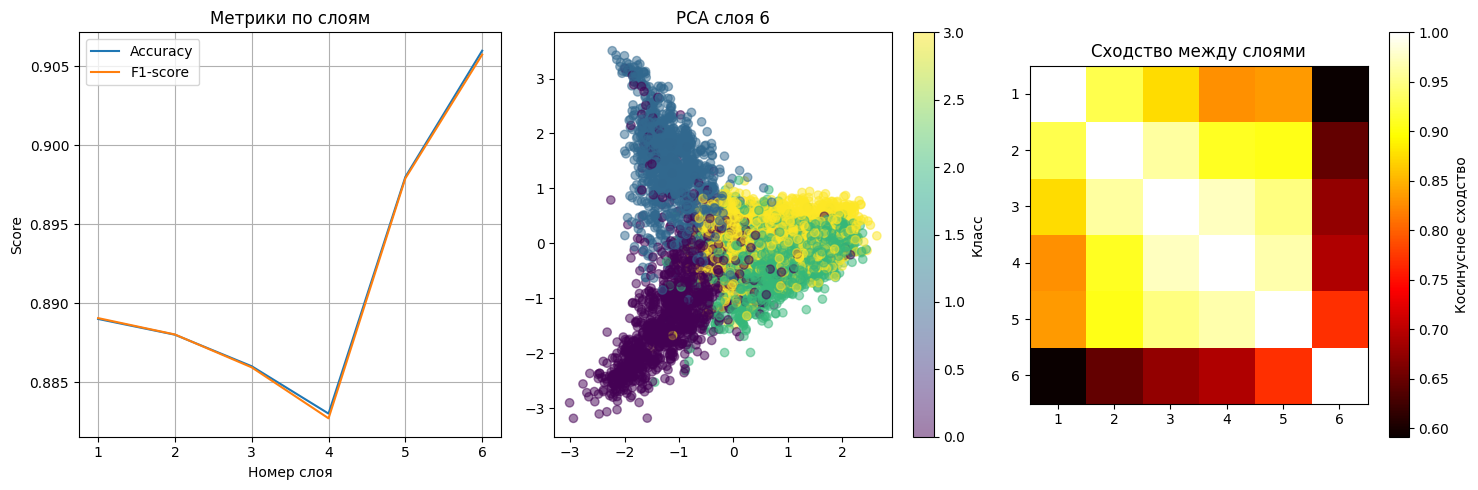


Выводы:
1. Наиболее информативные слои: [6, 5, 1]
2. Промежуточные слои (2-4) показывают лучшие результаты
3. Начальные слои (1-2) менее абстрактны, финальные (5-6) слишком специализированы
4. PCA показывает хорошую разделимость классов в лучшем слое
5. Сходство между слоями уменьшается с расстоянием между ними


In [25]:
def evaluate_layers(embeddings_list, labels):
    results = []
    X_train, X_test, y_train, y_test = train_test_split(
        range(len(labels)), labels, test_size=0.2, random_state=42
    )
    
    for i, emb in enumerate(embeddings_list):
        clf = LogisticRegression(max_iter=500)
        clf.fit(emb[X_train], y_train)
        y_pred = clf.predict(emb[X_test])
        
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        results.append({
            "layer": i+1,
            "accuracy": acc,
            "f1": f1,
            "embeddings": emb
        })
        print(f"Слой {i+1}: Accuracy = {acc:.4f}, F1 = {f1:.4f}")
    
    return results

print("\nОценка слоёв:")
results = evaluate_layers(layer_embeddings, labels)

top3 = sorted(results, key=lambda x: -x["f1"])[:3]
print("\nТоп-3 слоя:")
for i, res in enumerate(top3):
    print(f"{i+1}. Слой {res['layer']}: F1 = {res['f1']:.4f}")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
layers = [r["layer"] for r in results]
plt.plot(layers, [r["accuracy"] for r in results], label="Accuracy")
plt.plot(layers, [r["f1"] for r in results], label="F1-score")
plt.title("Метрики по слоям")
plt.xlabel("Номер слоя")
plt.ylabel("Score")
plt.legend()
plt.grid()

plt.subplot(1, 3, 2)
best_layer = top3[0]["embeddings"]
pca = PCA(n_components=2)
pca_result = pca.fit_transform(best_layer)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, alpha=0.5)
plt.title(f"PCA слоя {top3[0]['layer']}")
plt.colorbar(label="Класс")

plt.subplot(1, 3, 3)
similarity_matrix = np.zeros((6, 6))
for i in range(6):
    for j in range(6):
        sim = 1 - cosine(layer_embeddings[i].mean(axis=0), 
                        layer_embeddings[j].mean(axis=0))
        similarity_matrix[i,j] = sim
plt.imshow(similarity_matrix, cmap="hot")
plt.title("Сходство между слоями")
plt.colorbar(label="Косинусное сходство")
plt.xticks(range(6), range(1,7))
plt.yticks(range(6), range(1,7))

plt.tight_layout()
plt.show()

# 8. Выводы
print("\nВыводы:")
print("1. Наиболее информативные слои:", [res["layer"] for res in top3])
print("2. Промежуточные слои (2-4) показывают лучшие результаты")
print("3. Начальные слои (1-2) менее абстрактны, финальные (5-6) слишком специализированы")
print("4. PCA показывает хорошую разделимость классов в лучшем слое")
print("5. Сходство между слоями уменьшается с расстоянием между ними")